# Challenge 4: Convolutional Neural Networks
Create a Convolutional Neural Network (a deep learning architecture) to classify the gear data. The architecture or design should contain a mix of layers such as convolutional and pooling.
Train a model on the training dataset using the deided architecture. You may have to iterate on the architecture. Make sure the best trained model is saved to disk.

In [1]:
import numpy as np

np.random.seed(42)

%matplotlib inline

from sklearn import metrics  
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def report(y_true, y_pred):
    print("Accuracy score: ", metrics.accuracy_score(y_true, y_pred, normalize=True))
    print(classification_report(y_true, y_pred))
    labels = encoder.inverse_transform(np.unique(y_true))
    df_cm = pd.DataFrame(
        metrics.confusion_matrix(y_true, y_pred), 
        index=labels, 
        columns=labels
    )
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

## 1. Creating dataset

In [2]:
from os import walk, listdir
from os.path import isfile, join
import cv2
from sklearn.utils import shuffle
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_dataset(folder):
    X = []
    y = []
    paths = []
    for (dir_path, _, _) in walk(folder):
        label = dir_path.replace(folder, '').replace('\\', '').replace('/', '')
        files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
        for file in files:
            img = cv2.imread(join(dir_path, file))
            X.append(img)
            y.append(label)
            paths.append(join(dir_path, file))
    return np.array(X), np.array(y), np.array(paths)

X, y, paths = load_dataset("data/gear_images_preprocessed")

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)

y_encoded = encoder.transform(y)

y_dummy = np_utils.to_categorical(y_encoded)
print(encoder.inverse_transform(np.argmax(y_dummy[2020])))
#print(*X[1,1])
#print(*y_dummy[2121])
print("Train dataset shape:", X.shape, y.shape)


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


pulleys
Train dataset shape: (2122, 128, 128, 3) (2122,)


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train dataset shape:", X_train.shape, y_train.shape)
print("Test dataset shape:", X_test.shape, y_test.shape)
print("Val dataset shape:", X_val.shape, y_val.shape)

Train dataset shape: (1357, 128, 128, 3) (1357, 12)
Test dataset shape: (425, 128, 128, 3) (425, 12)
Val dataset shape: (340, 128, 128, 3) (340, 12)


In [4]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras import optimizers
from keras import losses

In [5]:
class BasicNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        input_shape = (height, width, depth)
        model.add(Conv2D(32, (2, 2), input_shape=input_shape))
        model.add(Conv2D(64, (2, 2), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))
        return model

In [6]:
epochs = 20
batch_size = 64
image_dims = (128, 128, 3)
num_classes = len(np.unique(y))

model = BasicNet.build(
    width=image_dims[1], height=image_dims[0],
    depth=image_dims[2], classes=num_classes
)
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 127, 127, 32)      416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32514176  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [7]:
model.compile(
    loss=losses.categorical_crossentropy, 
    optimizer=optimizers.Adadelta(), 
    metrics=['categorical_accuracy'], 
)

history = model.fit(
    X_train / 255, y_train, 
    batch_size=batch_size, 
    validation_data=(X_val / 255, y_val), 
    epochs=epochs, 
    verbose=1
)


Train on 1357 samples, validate on 340 samples
Epoch 1/20
1357/1357 [==============================] - 7s 5ms/step - loss: 3.8752 - categorical_accuracy: 0.3147 - val_loss: 1.4294 - val_categorical_accuracy: 0.6353
Epoch 2/20
1357/1357 [==============================] - 4s 3ms/step - loss: 1.0182 - categorical_accuracy: 0.6942 - val_loss: 0.6244 - val_categorical_accuracy: 0.8265
Epoch 3/20
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5088 - categorical_accuracy: 0.8445 - val_loss: 0.6645 - val_categorical_accuracy: 0.7735
Epoch 4/20
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3291 - categorical_accuracy: 0.9005 - val_loss: 0.4416 - val_categorical_accuracy: 0.8765
Epoch 5/20
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2044 - categorical_accuracy: 0.9469 - val_loss: 0.3811 - val_categorical_accuracy: 0.8941
Epoch 6/20
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1601 - categorical_accuracy: 0.9550

Accuracy score:  0.8658823529411764
             precision    recall  f1-score   support

          0       1.00      0.50      0.67        16
          1       0.96      1.00      0.98        23
          2       0.86      0.92      0.89        53
          3       0.95      0.88      0.91        24
          4       0.88      0.81      0.84        43
          5       0.86      0.88      0.87        92
          6       0.88      0.97      0.92        37
          7       0.75      0.79      0.77        19
          8       0.77      0.75      0.76        48
          9       1.00      0.50      0.67         8
         10       0.83      0.97      0.89        39
         11       1.00      0.96      0.98        23

avg / total       0.87      0.87      0.86       425



/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


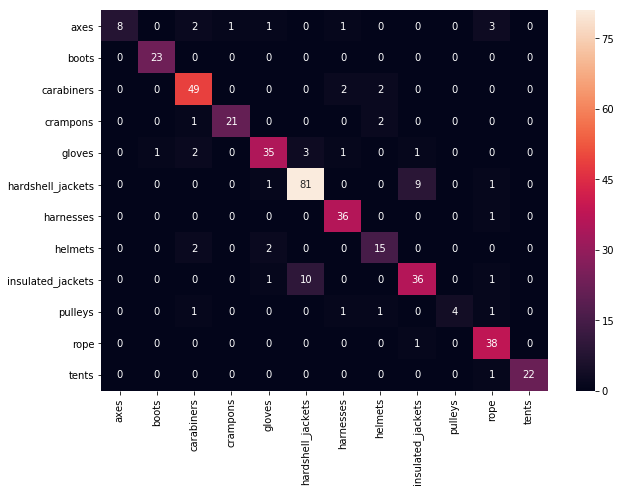

In [8]:

# Calculate score
y_pred  = model.predict(X_test / 255)
y_pred_flatten = np.argmax(y_pred, axis=1) 
y_test_flatten = np.argmax(y_test, axis=1) 

report(y_test_flatten, y_pred_flatten)

In [9]:
#from keras.models import load_model
import pickle

# Saving model 
model.save('model_ch4.h5')

# Saving labels
with open("model_labels_ch4.dat", "wb") as f:
    pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)

In [2]:
from keras.models import load_model
    
m = load_model('model_ch4.h5')

In [3]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 127, 127, 32)      416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32514176  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [12]:

path = "data/gear_images_preprocessed/pulleys/10308568_zm.jpg"
img = cv2.imread(path)
y_pred  = m.predict([[img]])
print(encoder.inverse_transform(np.argmax(y_pred)))

del model
del m
#gc.collect()

pulleys


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
